In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install adabelief-pytorch==0.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm
from glob import glob
import json
import requests
import tensorflow as tf
from transformers import BertModel, TFBertModel, TFRobertaModel, RobertaTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoModelForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from adabelief_pytorch import AdaBelief
from transformers.optimization import get_cosine_schedule_with_warmup
from tqdm import tqdm, tqdm_notebook
import shutil
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

여기서 하이퍼 파라미터 BATCH_SIZE, L_RATE 조절. 

In [ ]:
# random seed 고정
# 파라미터들 정의.
tf.random.set_seed(2023)
np.random.seed(2023)
BATCH_SIZE = 32
NUM_EPOCHS = 3

L_RATE = 1e-5
MAX_LEN = 128
max_grad_norm=1
log_interval=200
NUM_CORES = os.cpu_count()
device = torch.device("cuda:0")

In [ ]:
#pre-trained된 tokenizer, model 불러오기  
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base",num_labels=10)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [ ]:
#Google Drive 연동 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/NLP/Data/최종학습데이터세트_병합ver_전처리전단계_0116.csv',encoding = 'utf-8')
#하위 카테고리 drop
data.drop('하위 카테고리',axis = 1,inplace = True)
#label encoding
data['카테고리'] = data['카테고리'].replace(['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],[0,1,2,3,4,5,6,7,8,9])

In [ ]:
from sklearn.model_selection import train_test_split

#stratify train-test split

X_data = data['품목명']
y_data = data['카테고리']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=2023, stratify=y_data)

In [ ]:
# 정규표현식 통해 전처리 이후 train-valid split 위해 다시 합쳐주기 
train_data = pd.DataFrame([ x for x in zip(X_train,y_train)])
train_data.columns = ['품목명','label']
#마지막 결과 출력을 위한 test_data 저장.
last_test_data = pd.DataFrame([ x for x in zip(X_test,y_test)])
last_test_data.columns = ['품목명','label']

In [ ]:
import re
# 데이터 전처리 
# 괄호(),[],<> 안에 들어가있는 문자들 제거
train_data.replace('\[[^]]*\]', '', regex=True,inplace=True)
train_data.replace('\([^]]*\)', '', regex=True,inplace=True)
train_data.replace('\<[^]]*\>', '', regex=True,inplace=True)

# 특수문자를 띄어쓰기로 대체(특수문자: 영어, 한글, 숫자 제외한 문자들)
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'[^A-Za-z0-9가-힣]').sub(' ',x))

# 숫자를 공백(띄어쓰기 없음)으로 대체
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'[0-9]').sub('',x))

# 숫자를 공백으로 대체한 후, 중복값 제거
train_data.drop_duplicates(['품목명'], keep = 'first',ignore_index = True, inplace=True)

# 알파벳 길이가 1인 문자 제거
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'(?<=\s)([A-Za-z])(?=\s)').sub(' ',x))

In [ ]:
#stratify trian-valid split 
X_train, X_val, y_train, y_val = train_test_split(train_data['품목명'], train_data['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 2023, 
                                                    stratify = train_data['label'])

In [ ]:
#torch DataLoader를 위한 데이터 변형 
class transDataset(Dataset):
    def __init__(self, df):
        self.df_data = df
    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence = self.df_data.loc[index, '품목명']
        encoded_dict = tokenizer(
          text = sentence,
          add_special_tokens = True, 
          max_length = MAX_LEN,
          pad_to_max_length = True,
          truncation=True,           # Pad & truncate all sentences.
          return_tensors="pt")

        padded_token_list = encoded_dict['input_ids'][0]
        token_type_id = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        target = torch.tensor(self.df_data.loc[index, "label"])
        sample = (padded_token_list, token_type_id , att_mask, target)
        return sample
    def __len__(self):
        return len(self.df_data)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df):
        self.df_data = df
    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence = self.df_data.loc[index, '품목명']
        encoded_dict = tokenizer(
          text = sentence,
          add_special_tokens = True, 
          max_length = MAX_LEN,
          pad_to_max_length = True,
          truncation=True,           # Pad & truncate all sentences.
          return_tensors="pt")

        padded_token_list = encoded_dict['input_ids'][0]
        token_type_id = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        sample = (padded_token_list, token_type_id , att_mask)
        return sample
    def __len__(self):
        return len(self.df_data)

In [ ]:
#정확도 계산 함수 
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
train_data = pd.DataFrame([ x for x in zip(X_train,y_train)])
train_data.columns = ['품목명','label']

valid_data = pd.DataFrame([ x for x in zip(X_val,y_val)])
valid_data.columns = ['품목명','label']

test_data = pd.DataFrame([ x for x in zip(X_test,y_test)])
test_data.columns = ['품목명','label']

In [ ]:
#transDataset class 활용 
train_data = transDataset(train_data)

valid_data = transDataset(valid_data)

test_data = TestDataset(test_data)


#torch DataLoader 
train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                      num_workers=NUM_CORES)
valid_dataloader = torch.utils.data.DataLoader(valid_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                      num_workers=NUM_CORES)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                      num_workers=NUM_CORES)


In [ ]:
#model gpu에 할당
model.to(device)
#optimizer 정의 (AdaBelief 사용.)
optimizer = AdaBelief(model.parameters(), lr=5e-5, eps=1e-08, betas=(0.9,0.999), weight_decouple = True, rectify = False)

#warmup_ratio
warmup_ratio = 0.1
t_total = len(train_dataloader) * NUM_EPOCHS
warmup_step = int(t_total * warmup_ratio)

#scheduler 정의 (optimizer = Adabelief, warup_step, training_step)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [ ]:
#EPOCH 만큼 학습 시작. 
for e in range(NUM_EPOCHS):
    train_acc = 0.0
    valid_acc = 0.0
    #학습 
    model.train()
    torch.set_grad_enabled(True)
    #train_dataset
    for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        input_id = input_id.long().to(device)
        token_type_id = token_type_id.long().to(device)
        attention_mask = attention_mask.long().to(device)
        label = label.to(device)
        outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask, labels=label)
        loss = outputs[0]
        out = outputs[1]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    #valid_dataset
    for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(valid_dataloader)):
        optimizer.zero_grad()
        input_id = input_id.long().to(device)
        token_type_id = token_type_id.long().to(device)
        attention_mask = attention_mask.long().to(device)
        label = label.to(device)
        outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask, labels=label)
        loss = outputs[0]
        out = outputs[1]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        valid_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} valid acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), valid_acc / (batch_id+1)))
    print("epoch {} valid acc {}".format(e+1, valid_acc / (batch_id+1)))

<ipython-input-17-0dc0672f7893>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/23018 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 1 batch id 1 loss 2.308231830596924 train acc 0.09375


KeyboardInterrupt: ignored

In [ ]:
#모델 저장.
torch.save(model,'/content/drive/MyDrive/NLP/Models/' + 'klue_bertbase_sota_model.pth')  # 전체 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/Models/' + 'klue__bertbase_model_sota_state_dict.pth')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, '/content/drive/MyDrive/NLP/Models/' + 'klue_bertbase_sota_all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [ ]:
#test_dataset 결과 확인.
preds = [] 
model.eval()
torch.set_grad_enabled(False)
for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):
    input_id = input_id.long().to(device)
    token_type_id = token_type_id.long().to(device)
    attention_mask = attention_mask.long().to(device)
    outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask)
    out = outputs[0]
    for inp in out:
      preds.append(inp.detach().cpu().numpy())
Preds = np.array(preds)

<ipython-input-20-838013769f52>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/13032 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

ValueError: ignored

In [ ]:
#test_data에 예측값 Column 추가.
last_test_data['predict'] = np.argmax(Preds, axis=1)

In [ ]:
last_test_data

,품목명,label,predict
0,비비안 롱 코트 BACT52162,6,6
1,여성용 MTB 자전거 산악 로드 바퀴큰 MTB자전거 출퇴,1,1
2,여수새조개 자연산특품 손질 활새조개 샤브샤브 500g 1kg 산지직송 당일조업 채취 택배,2,2
3,베이직 누빔 굴곡형 라텍스 베개커버,4,4
4,포스터 스탠드 배너 안내판 입간판 슬림 사각 A3,9,4
...,...,...,...
417015,concombre 판다 맥주,0,0
417016,포인트 무소음 인테리어 소품 벽시계 부엉이 벽걸이시계 I-W4D0F38,4,4
417017,KD-48,5,5
417018,20대 캐주얼 핸드폰 책수납 크로스백 남자크로스백,7,7


In [ ]:
last_test_data['label'] = last_test_data['label'].replace([0,1,2,3,4,5,6,7,8,9],['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],)
last_test_data['predict'] = last_test_data['predict'].replace([0,1,2,3,4,5,6,7,8,9],['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
#classification report 확인.

cl_report = classification_report(last_test_data['predict'],last_test_data['label'], output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(10)
print(cl_report_df)

              precision    recall  f1-score        support
가구/인테리어        0.977414  0.973079  0.975242   32243.000000
디지털/가전         0.980528  0.971250  0.975867   55269.000000
생활/건강          0.932378  0.941406  0.936870   26129.000000
스포츠/레저         0.956555  0.961962  0.959251   48820.000000
식품             0.980976  0.977796  0.979383   34858.000000
여가/생활편의        0.927737  0.946009  0.936784   14521.000000
출산/육아          0.952243  0.961263  0.956732   58910.000000
패션의류           0.988146  0.984019  0.986078   81158.000000
패션잡화           0.979889  0.975234  0.977556   35573.000000
화장품/미용         0.974026  0.971191  0.972606   29539.000000
accuracy       0.969512  0.969512  0.969512       0.969512
macro avg      0.964989  0.966321  0.965637  417020.000000
weighted avg   0.969635  0.969512  0.969560  417020.000000


In [ ]:
accuracy	0.9554697616
macro avg	0.9534902424

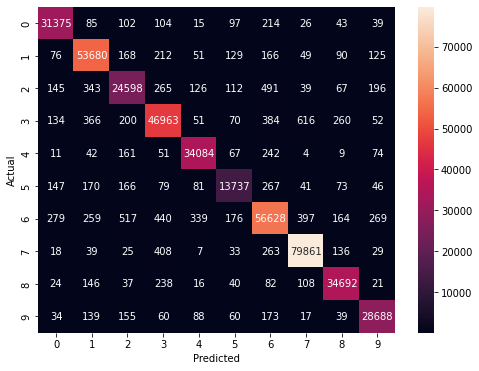

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#classification matrix 확인 
cf_matrix = confusion_matrix(last_test_data['label'], last_test_data['predict'])
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()